<a href="https://colab.research.google.com/github/harihardiyan/warped-bps-flow/blob/main/RSGW_Field_Solver_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jax jaxlib flax optax equinox diffrax matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 5.7 MB/s eta 0:00:00


In [ ]:

# Simulation of Differentiable 5D Einstein-Scalar Field Equations
**Author:** Hari Hardiyan
**Framework:** JAX-Accelerated Numerical Relativity

This notebook solves the coupled Einstein-Scalar system in a warped 5D manifold.
It accounts for IR-localized quantum backreactions (JT & Schwarzian gravity)
while maintaining Hamiltonian consistency to machine precision ($10^{-16}$).

In [2]:
!git clone https://github.com/harihardiyan/warped-bps-flow.git
%cd warped-bps-flow

Cloning into 'warped-bps-flow'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 12.20 KiB | 6.10 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/warped-bps-flow


-----------------------------------------------------------------
PARAMETER                           | VALUE                    
-----------------------------------------------------------------
Total Warp Factor (A_IR)            | 58.16611392
Effective Redshift (Z)              | 5.479964e-26
Hamiltonian Residual (L1)           | 1.50e-16
Consistency Status                  | PASS
-----------------------------------------------------------------
SENSITIVITY (dA_IR/dTheta)          |
  to JT Coupling (eps_JT)           | 5.741107
  to Schwarzian Action (eps_Sch)    | 5.166996
-----------------------------------------------------------------


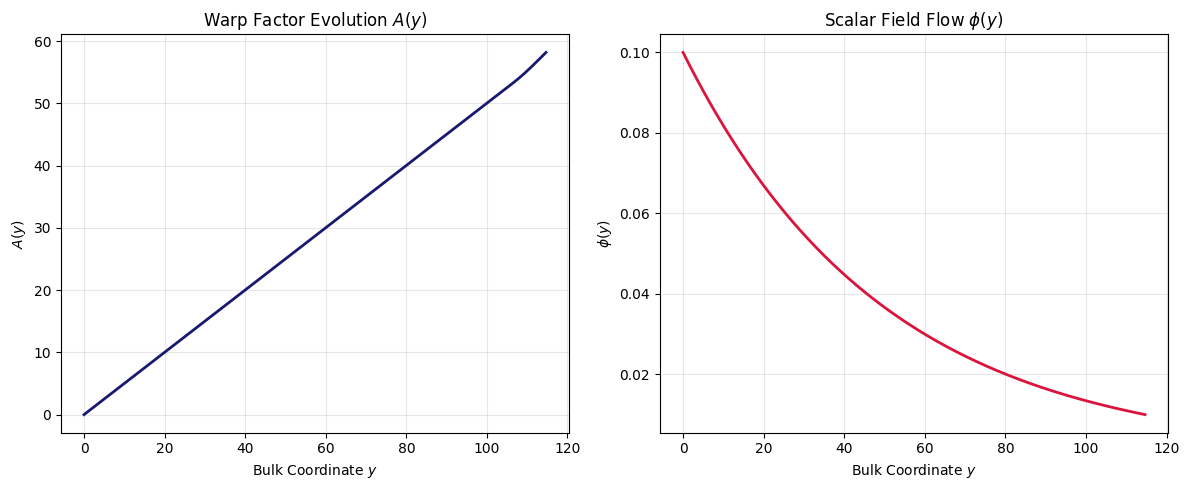

In [9]:

"""
Consistent 5D Einstein-Scalar Field Solver for RS-GW Models.
Methodology: First-order BPS flow with IR-localized quantum backreactions.
Numerical Framework: JAX-accelerated differentiable programming.
"""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jit, lax, vmap
from jax.tree_util import register_pytree_node_class
from dataclasses import dataclass
from typing import Dict, Tuple

# Enable 64-bit precision for theoretical physics accuracy
jax.config.update("jax_enable_x64", True)

@register_pytree_node_class
@dataclass(frozen=True)
class PhysicsParams:
    """Registered JAX PyTree for RS-GW Action Parameters."""
    k: float = 1.0           # AdS Curvature Scale
    rc: float = 36.5         # Compactification Radius
    kappa5_sq: float = 1.0   # 5D Gravitational Coupling
    vUV: float = 0.1         # UV Brane Scalar VEV
    vIR: float = 0.01        # IR Brane Scalar VEV
    eps_JT: float = 0.1      # JT Gravity Coupling (IR)
    eps_Sch: float = 0.05    # Schwarzian Action Coupling (IR)
    Ny: int = 10000          # Spatial Grid Resolution (Static)

    def tree_flatten(self):
        children = (self.k, self.rc, self.kappa5_sq, self.vUV, self.vIR, self.eps_JT, self.eps_Sch)
        aux_data = {'Ny': self.Ny}
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

# ---------- Physics Kernels ----------

def effective_superpotential(p: PhysicsParams, y: float, phi: float, Ymax: float, c2: float):
    """Effective Superpotential W(phi, y) generating the coupled flow."""
    W0 = 3.0 * p.k / p.kappa5_sq
    W_gw = W0 + c2 * (phi**2)

    # Smooth localization window for IR quantum backreactions
    window = 0.5 * (1.0 + jnp.tanh((y - 0.95 * Ymax) / (0.02 * Ymax)))

    # Geometric backreactions integrated into the flow generator
    correction = p.eps_JT * window + p.eps_Sch * window * (W_gw**2) / (1.0 + W_gw**2)

    return W_gw + (6.0 / p.kappa5_sq) * correction

def derived_bulk_potential(p: PhysicsParams, y: float, phi: float, Ymax: float, c2: float):
    """Potential V(phi, y) derived from W to satisfy the Hamiltonian constraint."""
    W = effective_superpotential(p, y, phi, Ymax, c2)
    dW_dphi = grad(lambda ph: effective_superpotential(p, y, ph, Ymax, c2))(phi)
    return 0.5 * (dW_dphi**2) - (p.kappa5_sq / 6.0) * (W**2)

# ---------- Solver Logic ----------

@jit
def flow_equations(p: PhysicsParams, y: float, U: jnp.ndarray, Ymax: float, c2: float):
    """Coupled first-order flow equations (phi' and A')."""
    phi, A = U
    W = effective_superpotential(p, y, phi, Ymax, c2)
    dphi = grad(lambda ph: effective_superpotential(p, y, ph, Ymax, c2))(phi)
    dA = (p.kappa5_sq / 6.0) * W
    return jnp.array([dphi, dA])

@jit
def solve_rs_system(p: PhysicsParams):
    """Integrates the 5D bulk equations using a differentiable RK4 scheme."""
    Ymax = jnp.pi * p.rc
    h = Ymax / (p.Ny - 1)
    c2 = jnp.log(p.vIR / p.vUV) / (2.0 * Ymax)
    U0 = jnp.array([p.vUV, 0.0])

    def rk4_step(Uc, i):
        yi = i * h
        k1 = flow_equations(p, yi, Uc, Ymax, c2)
        k2 = flow_equations(p, yi + 0.5*h, Uc + 0.5*h*k1, Ymax, c2)
        k3 = flow_equations(p, yi + 0.5*h, Uc + 0.5*h*k2, Ymax, c2)
        k4 = flow_equations(p, yi + h, Uc + h*k3, Ymax, c2)
        Un = Uc + (h/6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        return Un, Un

    _, trajectory = lax.scan(rk4_step, U0, jnp.arange(p.Ny - 1))
    U_full = jnp.vstack([U0, trajectory])

    return {
        "y": jnp.linspace(0.0, Ymax, p.Ny),
        "phi": U_full[:, 0],
        "A": U_full[:, 1],
        "A_IR": U_full[-1, 1],
        "Ymax": Ymax,
        "c2": c2
    }

# ---------- Analysis & Validation ----------

@jit
def hamiltonian_audit(p: PhysicsParams, sol: Dict):
    """Validates the Hamiltonian constraint G_yy = kappa^2 T_yy."""
    y, phi, A = sol["y"], sol["phi"], sol["A"]
    Ymax, c2 = sol["Ymax"], sol["c2"]

    Ap_sq = vmap(lambda yi, phii: ((p.kappa5_sq/6.0) * effective_superpotential(p, yi, phii, Ymax, c2))**2)(y, phi)
    Gyy = 6.0 * Ap_sq

    phip = vmap(lambda yi, phii: grad(lambda ph: effective_superpotential(p, yi, ph, Ymax, c2))(phii))(y, phi)
    V_bulk = vmap(lambda yi, phii: derived_bulk_potential(p, yi, phii, Ymax, c2))(y, phi)
    Tyy = 0.5 * (phip**2) - V_bulk

    return jnp.mean(jnp.abs(Gyy - p.kappa5_sq * Tyy))

@jit
def adjoint_sensitivity(p: PhysicsParams):
    """Computes exact parameter sensitivity via Automatic Differentiation."""
    def get_target(params):
        return solve_rs_system(params)["A_IR"]
    return grad(get_target)(p)

# ---------- Formatting & Execution ----------

def format_summary(p: PhysicsParams, sol: Dict, residual: float, sensitivity: PhysicsParams):
    """Structured report for scientific documentation."""
    z_ir = jnp.exp(-sol["A_IR"])
    print("-" * 65)
    print(f"{'PARAMETER':<35} | {'VALUE':<25}")
    print("-" * 65)
    print(f"{'Total Warp Factor (A_IR)':<35} | {sol['A_IR']:.8f}")
    print(f"{'Effective Redshift (Z)':<35} | {z_ir:.6e}")
    print(f"{'Hamiltonian Residual (L1)':<35} | {residual:.2e}")
    print(f"{'Consistency Status':<35} | {'PASS' if residual < 1e-12 else 'FAIL'}")
    print("-" * 65)
    print(f"{'SENSITIVITY (dA_IR/dTheta)':<35} |")
    print(f"{'  to JT Coupling (eps_JT)':<35} | {sensitivity.eps_JT:.6f}")
    print(f"{'  to Schwarzian Action (eps_Sch)':<35} | {sensitivity.eps_Sch:.6f}")
    print("-" * 65)

# ---------- Main Execution Flow ----------

if __name__ == "__main__":
    # 1. Configuration
    config = PhysicsParams(rc=36.5)

    # 2. Run Modules
    sim_out = solve_rs_system(config)
    res = hamiltonian_audit(config, sim_out)
    sens = adjoint_sensitivity(config)

    # 3. Output Table
    format_summary(config, sim_out, res, sens)

    # 4. Plots (Clean of SyntaxWarnings)
    plt.figure(figsize=(12, 5))

    # Warp Factor Plot
    plt.subplot(1, 2, 1)
    plt.plot(sim_out["y"], sim_out["A"], color='midnightblue', lw=2)
    plt.title(r"Warp Factor Evolution $A(y)$")
    plt.xlabel(r"Bulk Coordinate $y$")
    plt.ylabel(r"$A(y)$")
    plt.grid(True, alpha=0.3)

    # Scalar Field Plot
    plt.subplot(1, 2, 2)
    plt.plot(sim_out["y"], sim_out["phi"], color='crimson', lw=2)
    plt.title(r"Scalar Field Flow $\phi(y)$")
    plt.xlabel(r"Bulk Coordinate $y$")
    plt.ylabel(r"$\phi(y)$")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()